# ONNX Runtime推理预测-单张图像

同济子豪兄 2023-5-11

## 导入工具包

In [1]:
import cv2
import numpy as np
from PIL import Image

import onnxruntime

import torch
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
kpts_shape = [3, 3] # 关键点 shape

## 创建ONNX Runtime的InferenceSession

In [3]:
# ort_session = onnxruntime.InferenceSession('checkpoint/Triangle_215_yolov8l_pretrain.onnx', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

ort_session = onnxruntime.InferenceSession('checkpoint/best.onnx', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])


C:\Users\zhangyj21\.conda\envs\yongjie\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


## 输入一个随机Tensor，推理预测

In [4]:
import torch
x = torch.randn(1, 3, 640, 640).numpy()

In [5]:
x.shape

(1, 3, 640, 640)

In [6]:
ort_inputs = {'images': x}
ort_output = ort_session.run(['output0'], ort_inputs)[0]

In [7]:
ort_output.shape

(1, 14, 8400)

## 获得ONNX模型输入层和数据维度

In [8]:
model_input = ort_session.get_inputs()
input_name = [model_input[0].name]

In [9]:
input_name

['images']

In [10]:
input_shape = model_input[0].shape

In [11]:
input_shape

[1, 3, 640, 640]

In [12]:
input_height, input_width = input_shape[2:]

## 获得ONNX模型输出层和数据维度

In [13]:
model_output = ort_session.get_outputs()
output_name = [model_output[0].name]

In [14]:
output_name

['output0']

In [15]:
output_shape = model_output[0].shape

In [16]:
output_shape

[1, 14, 8400]

## 载入图像

In [17]:
img_path = 'images/Triangle_4.jpg'

In [18]:
# 导入 BGR 格式的图像
img_bgr = cv2.imread(img_path)

In [19]:
# 获取原图尺寸
img_bgr.shape

(3712, 5568, 3)

In [20]:
## BGR 转 RGB
# img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
# plt.imshow(img_rgb)
# plt.show()

## 预处理-缩放图像尺寸

In [21]:
# 预处理-缩放图像尺寸
img_bgr_640 = cv2.resize(img_bgr, [input_height, input_width])

In [22]:
img_bgr_640.shape

(640, 640, 3)

In [23]:
img_rgb_640 = img_bgr_640[:,:,::-1]

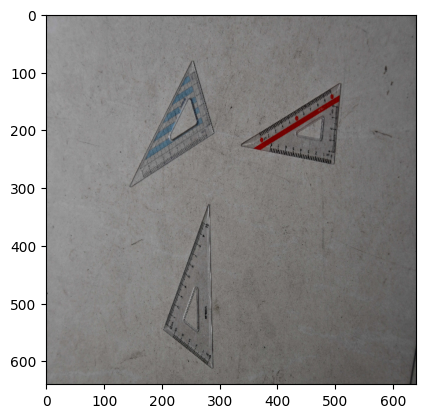

In [24]:
plt.imshow(img_rgb_640)
plt.show()

In [25]:
# X 方向 图像缩放比例
x_ratio = img_bgr.shape[1] / input_width

In [26]:
x_ratio

8.7

In [27]:
# Y 方向 图像缩放比例
y_ratio = img_bgr.shape[0] / input_height

In [28]:
y_ratio

5.8

## 预处理-构造输入张量

In [29]:
# 预处理-归一化
input_tensor = img_rgb_640 / 255

# 预处理-构造输入 Tensor
input_tensor = np.expand_dims(input_tensor, axis=0) # 加 batch 维度
input_tensor = input_tensor.transpose((0, 3, 1, 2)) # N, C, H, W
input_tensor = np.ascontiguousarray(input_tensor)   # 将内存不连续存储的数组，转换为内存连续存储的数组，使得内存访问速度更快
input_tensor = torch.from_numpy(input_tensor).to(device).float() # 转 Pytorch Tensor
# input_tensor = input_tensor.half() # 是否开启半精度，即 uint8 转 fp16，默认转 fp32 

In [30]:
input_tensor.shape

torch.Size([1, 3, 640, 640])

## 执行推理预测

In [31]:
# ONNX Runtime 推理预测
ort_output = ort_session.run(output_name, {input_name[0]: input_tensor.numpy()})[0]

# 转 Tensor
preds = torch.Tensor(ort_output)

In [32]:
preds.shape

torch.Size([1, 14, 8400])

## 后处理-置信度过滤、NMS过滤

In [33]:
from ultralytics.yolo.utils import ops

WARNING  'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING  'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")



In [34]:
preds = ops.non_max_suppression(preds, conf_thres=0.25, iou_thres=0.7, nc=1)

In [35]:
pred = preds[0]

In [36]:
pred.shape

torch.Size([3, 15])

In [37]:
pred

tensor([[335.3407, 118.2397, 511.5287, 263.0739,   0.9496,   0.0000, 339.7541, 226.3335,   0.8986, 508.7477, 140.2970,   0.9576, 490.3015, 246.3158,   0.9818],
        [140.7707,  76.0801, 294.1508, 304.0558,   0.9362,   0.0000, 140.7847, 287.2669,   0.8801, 260.9339,  88.4540,   0.9649, 304.5666, 187.1516,   0.9658],
        [198.1369, 328.2086, 291.9886, 615.3135,   0.8948,   0.0000, 279.3366, 333.6154,   0.9013, 294.1905, 606.4675,   0.9367, 188.6638, 548.6373,   0.9547]])

## 解析目标检测预测结果

In [38]:
pred_det = pred[:, :6].cpu().numpy()

In [39]:
# 目标检测预测结果：左上角X、左上角Y、右下角X、右下角Y、置信度、类别ID
pred_det

array([[     335.34,      118.24,      511.53,      263.07,      0.9496,           0],
       [     140.77,       76.08,      294.15,      304.06,     0.93616,           0],
       [     198.14,      328.21,      291.99,      615.31,     0.89481,           0]], dtype=float32)

In [40]:
num_bbox = len(pred_det)
print('预测出 {} 个框'.format(num_bbox))

预测出 3 个框


In [41]:
# 类别
bboxes_cls = pred_det[:, 5]

In [42]:
bboxes_cls

array([          0,           0,           0], dtype=float32)

In [43]:
# 置信度
bboxes_conf = pred_det[:, 4]

In [44]:
bboxes_conf

array([     0.9496,     0.93616,     0.89481], dtype=float32)

In [45]:
pred_det

array([[     335.34,      118.24,      511.53,      263.07,      0.9496,           0],
       [     140.77,       76.08,      294.15,      304.06,     0.93616,           0],
       [     198.14,      328.21,      291.99,      615.31,     0.89481,           0]], dtype=float32)

In [46]:
# 目标检测框 XYXY 坐标
# 还原为缩放之前原图上的坐标
pred_det[:, 0] = pred_det[:, 0] * x_ratio
pred_det[:, 1] = pred_det[:, 1] * y_ratio
pred_det[:, 2] = pred_det[:, 2] * x_ratio
pred_det[:, 3] = pred_det[:, 3] * y_ratio
bboxes_xyxy = pred_det[:, :4].astype('uint32')

In [47]:
bboxes_xyxy

array([[2917,  685, 4450, 1525],
       [1224,  441, 2559, 1763],
       [1723, 1903, 2540, 3568]], dtype=uint32)

## 解析关键点检测预测结果

In [48]:
pred_kpts = pred[:, 6:].view(len(pred), kpts_shape[0], kpts_shape[1])

In [49]:
pred_kpts.shape

torch.Size([3, 3, 3])

In [50]:
bboxes_keypoints = pred_kpts.cpu().numpy()

In [51]:
bboxes_keypoints

array([[[     339.75,      226.33,     0.89856],
        [     508.75,       140.3,      0.9576],
        [      490.3,      246.32,     0.98182]],

       [[     140.78,      287.27,     0.88007],
        [     260.93,      88.454,     0.96491],
        [     304.57,      187.15,     0.96585]],

       [[     279.34,      333.62,     0.90131],
        [     294.19,      606.47,     0.93675],
        [     188.66,      548.64,     0.95472]]], dtype=float32)

In [52]:
# 还原为缩放之前原图上的坐标
bboxes_keypoints[:,:,0] = bboxes_keypoints[:,:,0] * x_ratio
bboxes_keypoints[:,:,1] = bboxes_keypoints[:,:,1] * y_ratio
bboxes_keypoints = bboxes_keypoints.astype('uint32')

In [53]:
bboxes_keypoints

array([[[2955, 1312,    0],
        [4426,  813,    0],
        [4265, 1428,    0]],

       [[1224, 1666,    0],
        [2270,  513,    0],
        [2649, 1085,    0]],

       [[2430, 1934,    0],
        [2559, 3517,    0],
        [1641, 3182,    0]]], dtype=uint32)

## OpenCV可视化关键点

In [56]:
# 框（rectangle）可视化配置
bbox_color = (150, 0, 0)             # 框的 BGR 颜色
bbox_thickness = 6                   # 框的线宽

# 框类别文字
bbox_labelstr = {
    'font_size':4,         # 字体大小
    'font_thickness':10,   # 字体粗细
    'offset_x':0,          # X 方向，文字偏移距离，向右为正
    'offset_y':-80,        # Y 方向，文字偏移距离，向下为正
}

In [57]:
# 关键点 BGR 配色
kpt_color_map = {
    0:{'name':'angle_30', 'color':[255, 0, 0], 'radius':40},      # 30度角点
    1:{'name':'angle_60', 'color':[0, 255, 0], 'radius':40},      # 60度角点
    2:{'name':'angle_90', 'color':[0, 0, 255], 'radius':40},      # 90度角点
}

# 点类别文字
kpt_labelstr = {
    'font_size':4,             # 字体大小
    'font_thickness':10,       # 字体粗细
    'offset_x':30,             # X 方向，文字偏移距离，向右为正
    'offset_y':120,            # Y 方向，文字偏移距离，向下为正
}

# 骨架连接 BGR 配色
skeleton_map = [
    {'srt_kpt_id':0, 'dst_kpt_id':1, 'color':[196, 75, 255], 'thickness':3},        # 30度角点-60度角点
    {'srt_kpt_id':0, 'dst_kpt_id':2, 'color':[180, 187, 28], 'thickness':3},        # 30度角点-90度角点
    {'srt_kpt_id':1, 'dst_kpt_id':2, 'color':[47,255, 173], 'thickness':3},         # 60度角点-90度角点
]

In [58]:
for idx in range(num_bbox): # 遍历每个框
    
    # 获取该框坐标
    bbox_xyxy = bboxes_xyxy[idx] 
    
    # 获取框的预测类别（对于关键点检测，只有一个类别）
    bbox_label = 'sjb_rect'
    
    # 画框
    img_bgr = cv2.rectangle(img_bgr, (bbox_xyxy[0], bbox_xyxy[1]), (bbox_xyxy[2], bbox_xyxy[3]), bbox_color, bbox_thickness)
    
    # 写框类别文字：图片，文字字符串，文字左上角坐标，字体，字体大小，颜色，字体粗细
    img_bgr = cv2.putText(img_bgr, bbox_label, (bbox_xyxy[0]+bbox_labelstr['offset_x'], bbox_xyxy[1]+bbox_labelstr['offset_y']), cv2.FONT_HERSHEY_SIMPLEX, bbox_labelstr['font_size'], bbox_color, bbox_labelstr['font_thickness'])
    
    bbox_keypoints = bboxes_keypoints[idx] # 该框所有关键点坐标和置信度
    
    # 画该框的骨架连接
    for skeleton in skeleton_map:
        
        # 获取起始点坐标
        srt_kpt_id = skeleton['srt_kpt_id']
        srt_kpt_x = bbox_keypoints[srt_kpt_id][0]
        srt_kpt_y = bbox_keypoints[srt_kpt_id][1]
        
        # 获取终止点坐标
        dst_kpt_id = skeleton['dst_kpt_id']
        dst_kpt_x = bbox_keypoints[dst_kpt_id][0]
        dst_kpt_y = bbox_keypoints[dst_kpt_id][1]
        
        # 获取骨架连接颜色
        skeleton_color = skeleton['color']
        
        # 获取骨架连接线宽
        skeleton_thickness = skeleton['thickness']
        
        # 画骨架连接
        img_bgr = cv2.line(img_bgr, (srt_kpt_x, srt_kpt_y),(dst_kpt_x, dst_kpt_y),color=skeleton_color,thickness=skeleton_thickness)
        
    # 画该框的关键点
    for kpt_id in kpt_color_map:
        
        # 获取该关键点的颜色、半径、XY坐标
        kpt_color = kpt_color_map[kpt_id]['color']
        kpt_radius = kpt_color_map[kpt_id]['radius']
        kpt_x = bbox_keypoints[kpt_id][0]
        kpt_y = bbox_keypoints[kpt_id][1]
        
        # 画圆：图片、XY坐标、半径、颜色、线宽（-1为填充）
        img_bgr = cv2.circle(img_bgr, (kpt_x, kpt_y), kpt_radius, kpt_color, -1)
        
        # 写关键点类别文字：图片，文字字符串，文字左上角坐标，字体，字体大小，颜色，字体粗细
        # kpt_label = str(kpt_id) # 写关键点类别 ID
        kpt_label = str(kpt_color_map[kpt_id]['name']) # 写关键点类别名称
        img_bgr = cv2.putText(img_bgr, kpt_label, (kpt_x+kpt_labelstr['offset_x'], kpt_y+kpt_labelstr['offset_y']), cv2.FONT_HERSHEY_SIMPLEX, kpt_labelstr['font_size'], kpt_color, kpt_labelstr['font_thickness'])

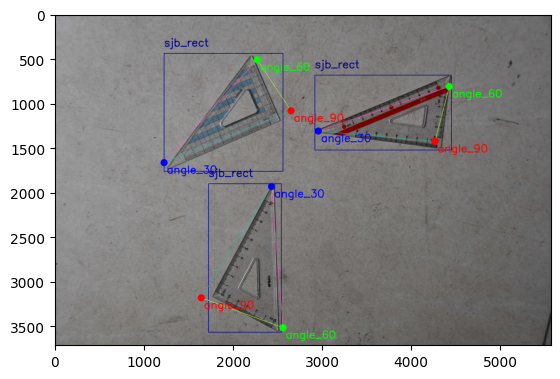

In [59]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()